In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model test

In [1]:
from glob import glob
from gtf import GTF
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transforkmers import analysis

plt.rcParams['figure.figsize'] = [8, 6]

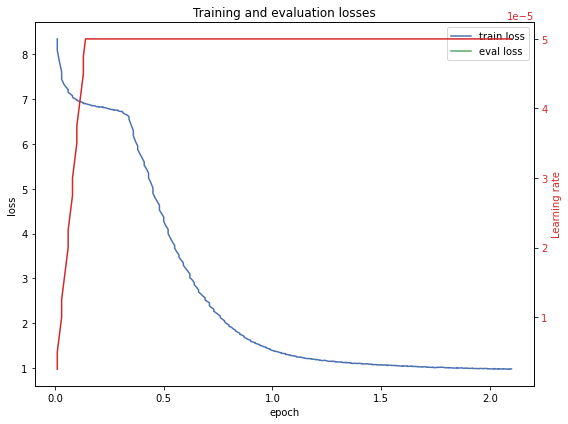

In [29]:
analysis.training_history("../models/pretrained_models_bb_12_768/checkpoint-150000/trainer_state.json", "pretrain_")

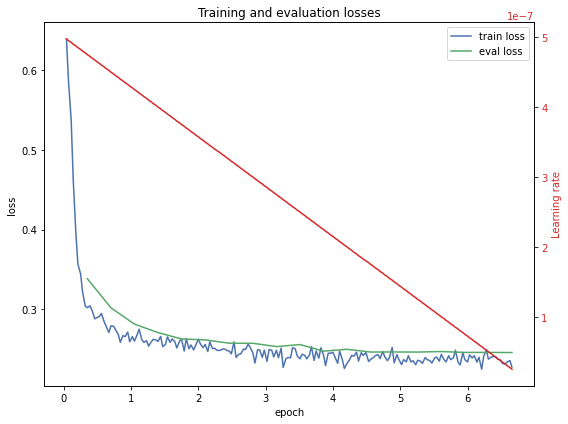

In [30]:
analysis.training_history("../models/hsa_5prime_bert_6_12-512/checkpoint-95000/trainer_state.json", "finetune_")

# Metrics

In [3]:
pred = pd.read_csv("/scratch/mlorthiois/test_bert/results/test/hsa/test.csv")
pred["predicted_label"] = pred["1"].round().astype(int)
pred

,ids,true_label,0,1,predicted_label
0,ENST00000373912,1,0.001229,0.998771,1
1,ENST00000651405,1,0.008651,0.991349,1
2,ENST00000571846,1,0.201855,0.798145,1
3,ENST00000566532_RANDOM::17:21714585-21715099,0,0.502949,0.497051,0
4,ENST00000669880,1,0.003199,0.996801,1
...,...,...,...,...,...
57007,ENST00000508973_RANDOM::8:41361701-41362215,0,0.148602,0.851398,1
57008,ENST00000556226,1,0.003848,0.996152,1
57009,ENST00000543485,1,0.015277,0.984723,1
57010,ENST00000588111,1,0.004745,0.995255,1


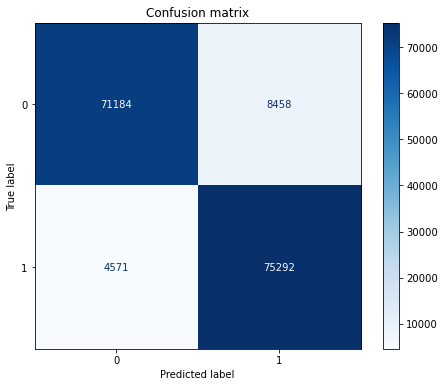

In [10]:
analysis.confusion_matrix(
    pred.true_label,
    pred.predicted_label,
    output_prefix=""
)

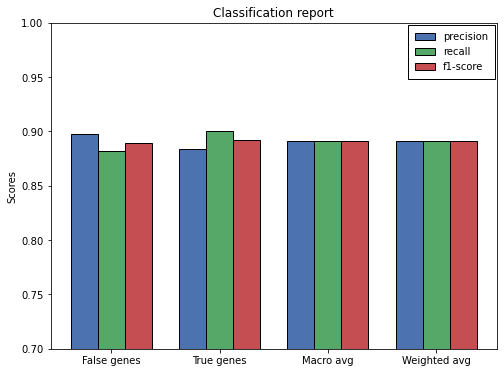

In [4]:
analysis.classification_report(
    pred.true_label,
    pred.predicted_label,
    output_prefix=""
)

{'roc': 0.49610013,
 'pr': 0.41798326,
 'accuracy': 0.495,
 'mean': 0.46969446333333337}

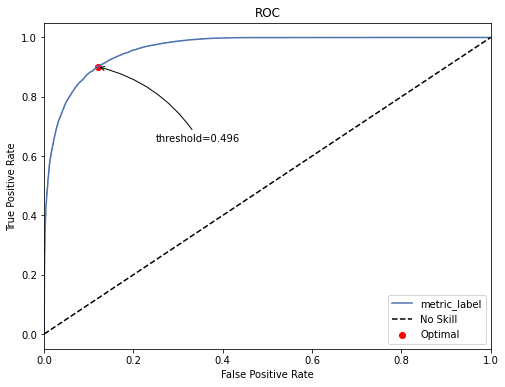

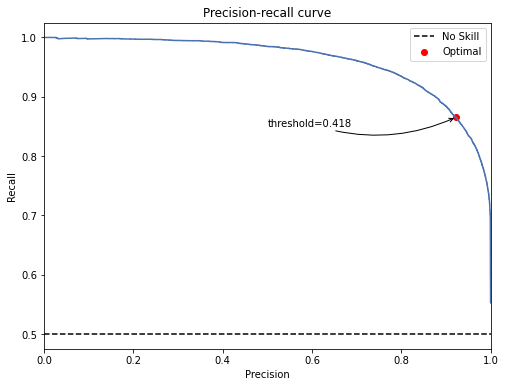

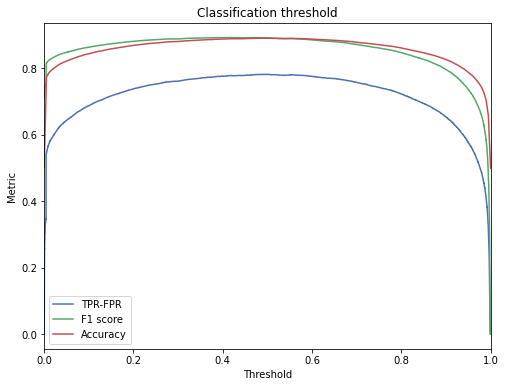

In [8]:
analysis.find_best_threshold(
    pred.true_label,
    pred["1"],
    "."
)

## Create dataset

In [24]:
RAWDIR = "../data/01_raw/"
gtfs = glob(f"{RAWDIR}/*.gtf")
with open("transcript_data.csv", "w") as w:
    w.write("transcript_id,biotype,tsl\n")
    for gtf in gtfs:
        with open(gtf) as fd:
            for tx in GTF.parse_by_line(fd, feature="transcript"):
                if "transcript_support_level" in tx:
                    tsl = tx["transcript_support_level"][0]
                else:
                    tsl = "N"
                w.write(f"{tx['transcript_id']},{tx['transcript_biotype']},{tsl}\n")

In [25]:
df = pd.read_csv("transcript_data.csv")

In [28]:
# Know origin of transcripts
pred["origin"] = "true"
pred.loc[pred.ids.str.endswith("shuffled"), "origin"] = "shuffled"
pred.loc[pred.ids.str.contains("RANDOM"), "origin"] = "random"
pred["correct"] = (pred.true_label == pred.predicted_label).astype(int)
pred

,ids,true_label,0,1,predicted_label,origin,correct
0,ENST00000244546,1,0.001024,0.999000,1,true,1
1,ENSMUST00000227982_shuffled,0,1.000000,0.000144,0,shuffled,1
2,XR_005354489_shuffled,0,1.000000,0.000310,0,shuffled,1
3,ENST00000307439,1,0.011154,0.988300,1,true,1
4,ENSMUST00000134140_shuffled,0,1.000000,0.000174,0,shuffled,1
...,...,...,...,...,...,...,...
159500,ENST00000613401,1,0.291300,0.708500,1,true,1
159501,ENST00000470947_RANDOM::16:34275749-34276261,0,0.999000,0.000767,0,random,1
159502,ENSMUST00000023352_shuffled,0,1.000000,0.000419,0,shuffled,1
159503,ENSMUST00000115031_RANDOM::X:126303745-126304259,0,0.587000,0.413000,0,random,1


In [29]:
m = df.merge(pred, left_on="transcript_id", right_on="ids", how="right")
m.drop(["transcript_id"], axis=1, inplace=True)
m

,biotype,tsl,ids,true_label,0,1,predicted_label,origin,correct
0,protein_coding,1,ENST00000244546,1,0.001024,0.999000,1,true,1
1,NaN,NaN,ENSMUST00000227982_shuffled,0,1.000000,0.000144,0,shuffled,1
2,NaN,NaN,XR_005354489_shuffled,0,1.000000,0.000310,0,shuffled,1
3,protein_coding,1,ENST00000307439,1,0.011154,0.988300,1,true,1
4,NaN,NaN,ENSMUST00000134140_shuffled,0,1.000000,0.000174,0,shuffled,1
...,...,...,...,...,...,...,...,...,...
159500,lncRNA,N,ENST00000613401,1,0.291300,0.708500,1,true,1
159501,NaN,NaN,ENST00000470947_RANDOM::16:34275749-34276261,0,0.999000,0.000767,0,random,1
159502,NaN,NaN,ENSMUST00000023352_shuffled,0,1.000000,0.000419,0,shuffled,1
159503,NaN,NaN,ENSMUST00000115031_RANDOM::X:126303745-126304259,0,0.587000,0.413000,0,random,1


In [33]:
# Specie
m["specie"] = "dog"
m.loc[m.ids.str.startswith("ENST"), 'specie'] = "human"
m.loc[m.ids.str.startswith("ENSMUST"), 'specie'] = "mouse"

m.set_index('ids', inplace=True)
m

,biotype,tsl,true_label,0,1,predicted_label,origin,correct,specie
ids,,,,,,,,,
ENST00000244546,protein_coding,1,1,0.001024,0.999000,1,true,1,human
ENSMUST00000227982_shuffled,NaN,NaN,0,1.000000,0.000144,0,shuffled,1,mouse
XR_005354489_shuffled,NaN,NaN,0,1.000000,0.000310,0,shuffled,1,dog
ENST00000307439,protein_coding,1,1,0.011154,0.988300,1,true,1,human
ENSMUST00000134140_shuffled,NaN,NaN,0,1.000000,0.000174,0,shuffled,1,mouse
...,...,...,...,...,...,...,...,...,...
ENST00000613401,lncRNA,N,1,0.291300,0.708500,1,true,1,human
ENST00000470947_RANDOM::16:34275749-34276261,NaN,NaN,0,0.999000,0.000767,0,random,1,human
ENSMUST00000023352_shuffled,NaN,NaN,0,1.000000,0.000419,0,shuffled,1,mouse


In [34]:
m.to_csv("full_test.csv")

## EDA

In [199]:
m.groupby(["specie", "biotype"]).size()

specie  biotype                       
dog     lncRNA                            1759
        protein_coding                    2970
human   TEC                                  1
        lncRNA                            3923
        non_stop_decay                       3
        nonsense_mediated_decay           1447
        processed_transcript              2401
        protein_coding                    7077
        pseudogene                           1
        retained_intron                   2654
        transcribed_unitary_pseudogene       2
mouse   TEC                                  4
        lncRNA                            1440
        non_stop_decay                       2
        nonsense_mediated_decay            678
        processed_pseudogene                 1
        processed_transcript              1388
        protein_coding                    5179
        pseudogene                           2
        retained_intron                   2115
dtype: int64

## Origin

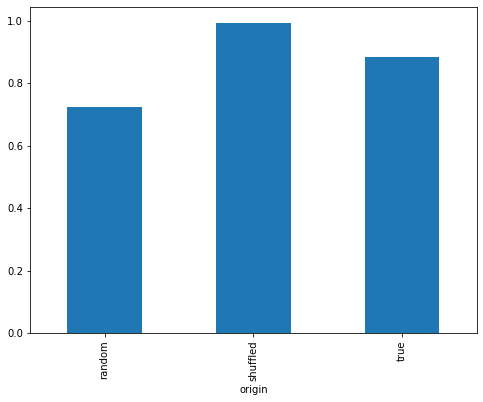

In [274]:
pred.groupby("origin")
    .correct.mean()
    .plot.bar();

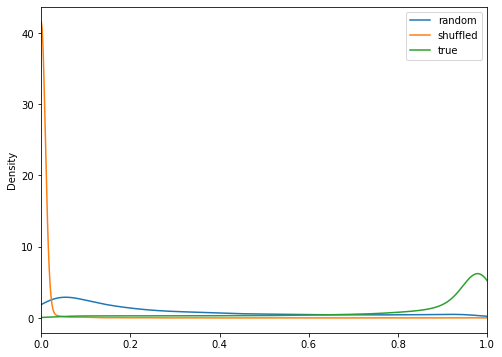

In [275]:
pred.groupby("origin")
    .probability.plot.density(legend=True, xlim=(0,1));

## Species

In [227]:
m.groupby("specie").size()

specie
dog       4729
human    17509
mouse    10809
dtype: int64

In [208]:
m.groupby("specie").correct.mean()

specie
dog      0.895961
human    0.836313
mouse    0.949394
Name: correct, dtype: float64

## Biotypes

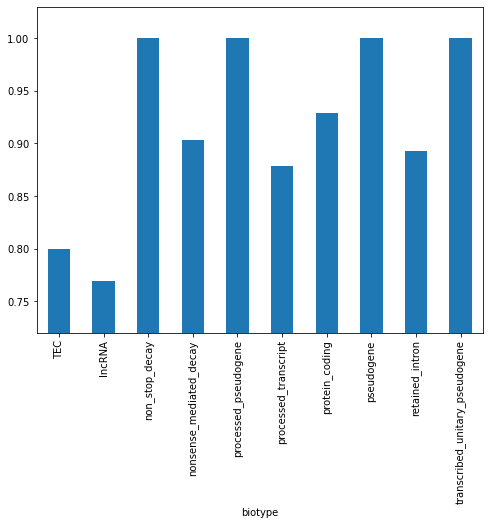

In [399]:
m.groupby("biotype")
    .correct.mean()
    .plot.bar(ylim=(0.72, 1.03));

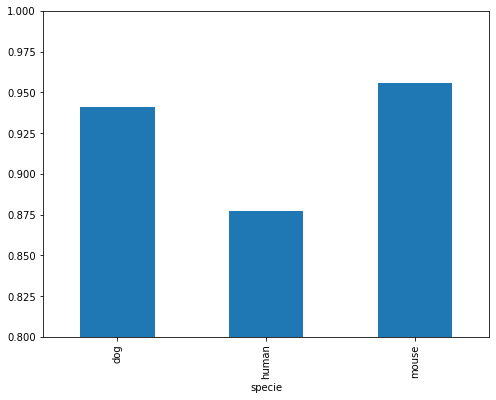

In [394]:
m[m.biotype != "lncRNA"]
    .groupby("specie")
    .correct.mean()
    .plot.bar(ylim=(0.8, 1));

## Biotype by species

In [408]:
m.groupby(["specie", "biotype"]).size() / m.groupby("specie").size()

specie  biotype                       
dog     lncRNA                            0.371960
        protein_coding                    0.628040
human   TEC                               0.000057
        lncRNA                            0.224056
        non_stop_decay                    0.000171
        nonsense_mediated_decay           0.082643
        processed_transcript              0.137129
        protein_coding                    0.404192
        pseudogene                        0.000057
        retained_intron                   0.151579
        transcribed_unitary_pseudogene    0.000114
mouse   TEC                               0.000370
        lncRNA                            0.133222
        non_stop_decay                    0.000185
        nonsense_mediated_decay           0.062726
        processed_pseudogene              0.000093
        processed_transcript              0.128412
        protein_coding                    0.479138
        pseudogene                        0

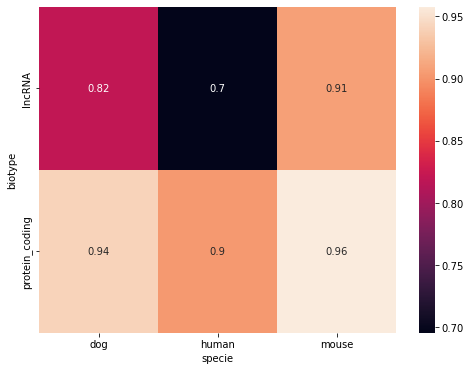

In [355]:
sns.heatmap(
    m.groupby(by=["specie", "biotype"], as_index=False)
        .correct.mean()
        .pivot(index='biotype', columns='specie', values='correct')
        .dropna(), 
    annot=True
);

## Influence of transcript support level (tsl)

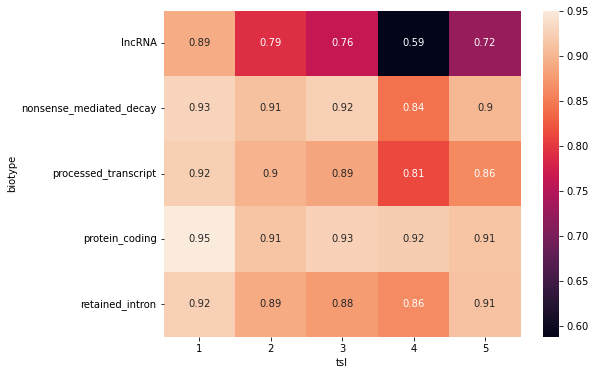

In [400]:
sns.heatmap(
    m[m.tsl != "N"]
        .groupby(["biotype", "tsl"], as_index=False)
        .correct.mean()
        .pivot(index='biotype', columns='tsl', values='correct')
        .dropna(), 
    annot=True
);

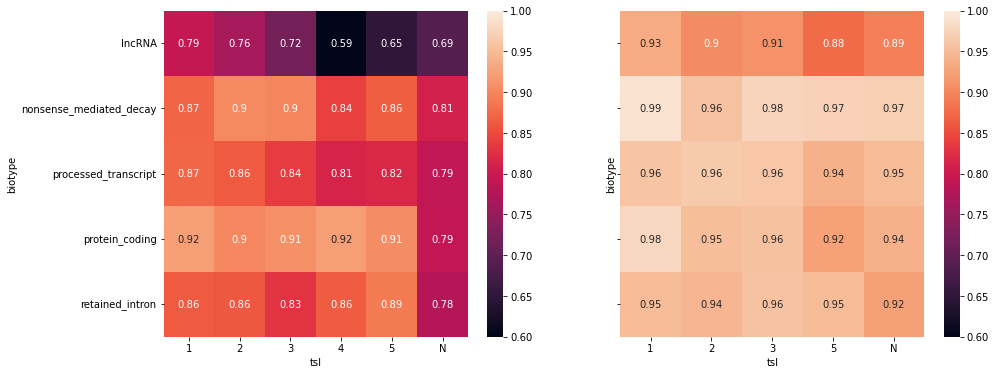

In [368]:
fig, ax = plt.subplots(1, 2, sharey=True,figsize=(15,6))
sns.heatmap(
    m[m.specie=="human"]
        .groupby(["biotype", "tsl"], as_index=False)
        .correct.mean()
        .pivot(index='biotype', columns='tsl', values='correct')
        .dropna(), 
    annot=True,
    vmin=0.6,
    vmax=1,
    ax=ax[0]
)
sns.heatmap(
    m[m.specie=="mouse"]
        .groupby(["biotype", "tsl"], as_index=False)
        .correct.mean()
        .pivot(index='biotype', columns='tsl', values='correct')
        .dropna(), 
    annot=True,
    vmin=0.6,
    vmax=1,
    ax=ax[1]
);

# CAGE

In [8]:
with (
    open("../data/04_postprocess/HSA.5prime_validCAGE1tpm_1rep.fantom5.gtf") as fd,
    open("validated_tx.csv", "w") as wr
):
    wr.write("ids,validated\n")
    for record in GTF.parse_by_line(fd):
        wr.write(f'{record["transcript_id"]},1\n')